In [148]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import pandas
import os

In [149]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)

In [150]:
def moving_average(data,period):
    return data['close'].rolling(period).mean()
def EMA(data,span):
    return data['close'].ewm(span=span).mean()
def MACD(data):
    data['DIF'] = data['EMA_12'] - data['EMA_26']
    data['DEM'] = data['DIF'].ewm(span=9).mean()
    data['OSC'] = data['DIF'] - data['DEM']
    return data
def KD(data):
    data_df = data.copy()
    data_df['min'] = data_df['low'].rolling(9).min()
    data_df['max'] = data_df['high'].rolling(9).max()
    data_df['RSV'] = (data_df['close'] - data_df['min'])/(data_df['max'] - data_df['min'])
    data_df = data_df.dropna()
    # 計算K
    # K的初始值定為50
    K_list = [50]
    for num,rsv in enumerate(list(data_df['RSV'])):
        K_yestarday = K_list[num]
        K_today = 2/3 * K_yestarday + 1/3 * rsv
        K_list.append(K_today)
    data_df['K'] = K_list[1:]
    # 計算D
    # D的初始值定為50
    D_list = [50]
    for num,K in enumerate(list(data_df['K'])):
        D_yestarday = D_list[num]
        D_today = 2/3 * D_yestarday + 1/3 * K
        D_list.append(D_today)
    data_df['D'] = D_list[1:]
    use_df = pd.merge(data,data_df[['K','D']],left_index=True,right_index=True,how='left')
    return use_df

def RSI(data):
    def cal_U(num):
        if num >= 0:
            return num
        else:
            return 0
    def cal_D(num):
        num = -num
        return cal_U(num)
    
    data['Dif'] = data['close'].diff()
    data['U'] = data['Dif'].apply(cal_U)
    data['D'] = data['Dif'].apply(cal_D)
    data['ema_U'] = data['U'].ewm(span=14).mean()
    data['ema_D'] = data['D'].ewm(span=14).mean()
    data['RS'] = data['ema_U'].div(data['ema_D'])
    data['RSI'] = data['RS'].apply(lambda rs:rs/(1+rs) * 100)
    return data['RSI']

def OBV(data):
    return (data['close']-data['low']).div(data['high']-data['low'])

In [151]:
df = KD(df)
df['MA_5']=moving_average(df,5)
df['MA_10']=moving_average(df,10)
df['MA_20']=moving_average(df,20)
df['MA_60']=moving_average(df,60)
df['MA_240']=moving_average(df,240)
df['EMA_12']=EMA(df,12)
df['EMA_26']=EMA(df,26)
df = MACD(df)
df['RSI']=RSI(df)
df['OBV']=OBV(df)
df.tail()


,adj_close,close,high,low,open,volume,date,year,month,day,...,DIF,DEM,OSC,Dif,U,ema_U,ema_D,RS,RSI,OBV
4111,443.0,443.0,445.0,435.0,435.0,44691239,20201007,2020,10,7,...,2.534615,3.235514,-0.700899,3.5,3.5,2.816649,1.711210,1.645998,62.207079,0.800000
4112,453.0,453.0,454.0,448.5,450.0,60853811,20201008,2020,10,8,...,3.707340,3.329879,0.377461,10.0,10.0,3.774429,1.483049,2.545047,71.791629,0.818182
4113,459.5,460.0,462.0,457.5,458.0,67645223,20201012,2020,10,12,...,5.142297,3.692363,1.449935,7.0,7.0,4.204505,1.285309,3.271202,76.587386,0.555556
4114,462.0,462.0,465.0,456.5,465.0,46303738,20201013,2020,10,13,...,6.367494,4.227389,2.140105,2.0,2.0,3.910571,1.113934,3.510594,77.829969,0.647059
4115,458.5,459.0,461.0,457.0,460.5,52677241,20201014,2020,10,14,...,7.015526,4.785016,2.230509,-3.0,0.0,3.389162,1.365410,2.482157,71.282168,0.500000


In [152]:
df.replace([np.inf, -np.inf], np.nan,inplace=True)
print(df.head())
df.dropna(inplace=True)
df

   adj_close  close  high   low  open    volume      date  year  month  day  \
0       63.5   64.0  64.5  63.5  64.5  18589704  20040211  2004      2   11   
1       64.0   64.5  65.0  64.0  64.0  48648900  20040212  2004      2   12   
2       64.0   64.0  64.5  63.5  64.5  28300096  20040213  2004      2   13   
3       62.5   62.5  64.0  62.5  64.0  43881575  20040216  2004      2   16   
4       62.5   62.5  63.5  62.5  62.5  31506459  20040217  2004      2   17   

   ...       DIF       DEM       OSC  Dif    U     ema_U     ema_D        RS  \
0  ...  0.000000  0.000000  0.000000  NaN  0.0  0.000000  0.000000       NaN   
1  ...  0.011218  0.006232  0.004986  0.5  0.5  0.267857  0.000000       NaN   
2  ... -0.001211  0.003182 -0.004393 -0.5  0.0  0.165535  0.191002  0.866667   
3  ... -0.060991 -0.018557 -0.042434 -1.5  0.0  0.114893  0.591461  0.194253   
4  ... -0.092191 -0.040462 -0.051729  0.0  0.0  0.084918  0.437150  0.194253   

         RSI  OBV  
0        NaN  0.5  
1   

,adj_close,close,high,low,open,volume,date,year,month,day,...,DIF,DEM,OSC,Dif,U,ema_U,ema_D,RS,RSI,OBV
239,49.0,49.1,49.2,48.6,48.9,42294267,20050118,2005,1,18,...,-0.214650,-0.076079,-0.138571,0.2,0.2,0.353754,0.258762,1.367105,57.754298,0.833333
240,47.7,47.7,49.3,47.7,49.1,31281266,20050119,2005,1,19,...,-0.255757,-0.112014,-0.143742,-1.4,0.0,0.306587,0.410927,0.746087,42.729080,0.000000
241,48.0,48.0,48.5,47.4,47.4,39515519,20050120,2005,1,20,...,-0.261116,-0.141835,-0.119282,0.3,0.3,0.305709,0.356137,0.858403,46.190367,0.545455
242,47.5,47.5,48.0,47.5,47.7,28724975,20050121,2005,1,21,...,-0.302226,-0.173913,-0.128313,-0.5,0.0,0.264948,0.375318,0.705928,41.380870,0.000000
243,47.0,47.0,47.6,46.9,47.5,23761097,20050124,2005,1,24,...,-0.370876,-0.213306,-0.157571,-0.5,0.0,0.229621,0.391943,0.585854,36.942509,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111,443.0,443.0,445.0,435.0,435.0,44691239,20201007,2020,10,7,...,2.534615,3.235514,-0.700899,3.5,3.5,2.816649,1.711210,1.645998,62.207079,0.800000
4112,453.0,453.0,454.0,448.5,450.0,60853811,20201008,2020,10,8,...,3.707340,3.329879,0.377461,10.0,10.0,3.774429,1.483049,2.545047,71.791629,0.818182
4113,459.5,460.0,462.0,457.5,458.0,67645223,20201012,2020,10,12,...,5.142297,3.692363,1.449935,7.0,7.0,4.204505,1.285309,3.271202,76.587386,0.555556
4114,462.0,462.0,465.0,456.5,465.0,46303738,20201013,2020,10,13,...,6.367494,4.227389,2.140105,2.0,2.0,3.910571,1.113934,3.510594,77.829969,0.647059


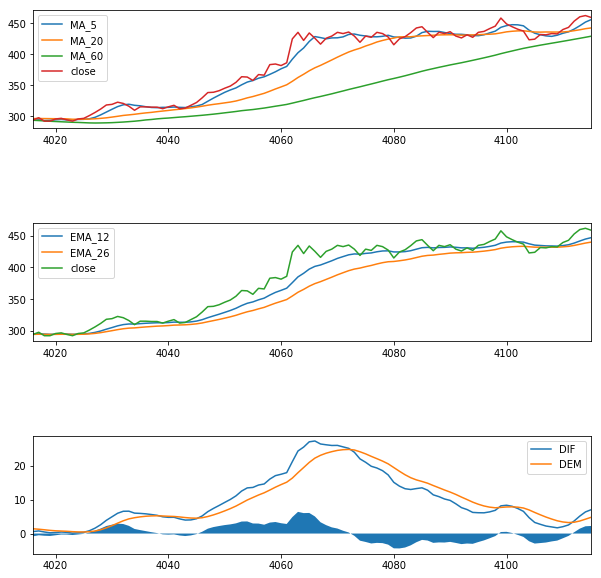

In [153]:
tsmc = df.iloc[-100:]
fig,ax = plt.subplots(3,1,figsize=(10,10))
plt.subplots_adjust(hspace=0.8)
tsmc['MA_5'].plot(ax=ax[0])
tsmc['MA_20'].plot(ax=ax[0])
tsmc['MA_60'].plot(ax=ax[0])
tsmc['EMA_12'].plot(ax=ax[1])
tsmc['EMA_26'].plot(ax=ax[1])
tsmc['close'].plot(ax=ax[0])
tsmc['close'].plot(ax=ax[1])
ax[0].legend()
ax[1].legend()
tsmc['DIF'].plot(ax=ax[2])
tsmc['DEM'].plot(ax=ax[2])
ax[2].fill_between(tsmc.index,0,tsmc['OSC'])
ax[2].legend()
plt.show()